Мышковец С.А., v.1 14.03.2023

Решение задачи:

Выполнить классификацию твитов из предоставленного набора данных с использованием рекурентных нейронных сетей по 4 классам.

Вывод:

Максимальная точность на валидационной выборке - 92,9%.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

**Загрузим данные.**

In [2]:
train_df = pd.read_csv('twitter_training.csv', header=None,names=['model', 'video', 'emotion', 'twit'])

In [3]:
train_df.head(3)

,model,video,emotion,twit
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   model    74682 non-null  int64 
 1   video    74682 non-null  object
 2   emotion  74682 non-null  object
 3   twit     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
train_df.emotion.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

**Удалим записи с пустыми твиттами и лишние столбцы.**

In [6]:
train_df.isna().sum()

model        0
video        0
emotion      0
twit       686
dtype: int64

In [7]:
train_df = train_df.drop(train_df[train_df.twit.isna()].index)

In [8]:
train_df = train_df.drop(['model', 'video'], axis=1)

**Закодируем таргеты и удалим исходную колонку.**

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [10]:
train_df["le_emotion"] = le.fit_transform(train_df["emotion"])

In [11]:
train_df = train_df.drop(['emotion'], axis=1)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   twit        73996 non-null  object
 1   le_emotion  73996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [13]:
train_df.head(3)

,twit,le_emotion
0,im getting on borderlands and i will murder yo...,3
1,I am coming to the borders and I will kill you...,3
2,im getting on borderlands and i will kill you ...,3


array([[<AxesSubplot: title={'center': 'le_emotion'}>]], dtype=object)

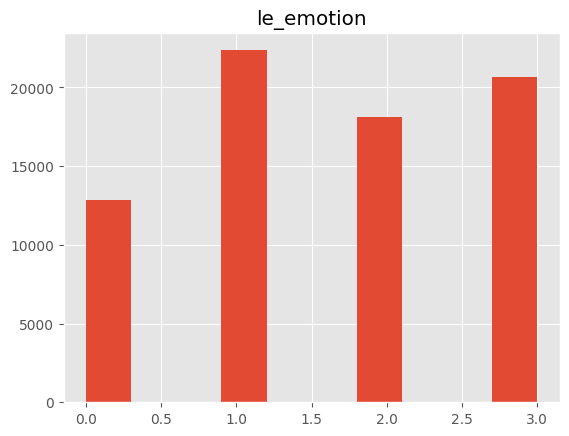

In [14]:
train_df.hist()

**Классы относительно сбалансированые.**

---

**Повторим выше указанные действия на валидационной выборке.**

In [15]:
valid_df = pd.read_csv('twitter_validation.csv', header=None,names=['model', 'video', 'emotion', 'twit'])

In [16]:
valid_df.head(3)

,model,video,emotion,twit
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [17]:
valid_df.isna().sum()

model      0
video      0
emotion    0
twit       0
dtype: int64

In [18]:
valid_df["le_emotion"] = le.fit_transform(valid_df["emotion"])

In [19]:
valid_df = valid_df.drop(['emotion', 'video', 'model'], axis=1)

In [20]:
valid_df.head()

,twit,le_emotion
0,I mentioned on Facebook that I was struggling ...,0
1,BBC News - Amazon boss Jeff Bezos rejects clai...,2
2,@Microsoft Why do I pay for WORD when it funct...,1
3,"CSGO matchmaking is so full of closet hacking,...",1
4,Now the President is slapping Americans in the...,2


---

**Сформируем токенизатор на основе тренировочной и валидационной выборок.**

In [21]:
tokenazer_df = pd.concat([train_df, valid_df])

In [22]:
tokenazer_df.head(3)

,twit,le_emotion
0,im getting on borderlands and i will murder yo...,3
1,I am coming to the borders and I will kill you...,3
2,im getting on borderlands and i will kill you ...,3


In [23]:
word_count = []
len_tw = []
for tw in tokenazer_df['twit']:
    words = [w for w in tw.split(' ')]
    len_tw.append(len(words))
    word_count.extend(words)

**Найдем длину словаря.**

In [24]:
unique_words = set(word_count)

In [25]:
len(unique_words)

83850

In [26]:
max(len_tw)

198

In [27]:
min(len_tw)

1

In [28]:
sum(len_tw)/len(len_tw)

19.4236759293829

In [29]:
max_vocab = 50000
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(tokenazer_df.twit)

---

**Выделим из тенировочной выборки тестовую.**

In [30]:
X = train_df.twit
y = train_df.le_emotion

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=18, stratify=y)

**Токенизируем тренировочную и тестовую выборку признаков.**

In [32]:
X_train = tokenizer.texts_to_sequences(X_train)

In [33]:
# text = tokenizer.sequences_to_texts(X_train)

In [34]:
# text[1]

In [35]:
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=20)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=20)

---

**Сформируем модель.**

In [37]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 64), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_1.summary()

2023-03-15 15:54:02.306726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 15:54:02.306864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          3200000   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                      

In [38]:
checkpoint_cb_1 = tf.keras.callbacks.ModelCheckpoint("model_1.h5", 
                                     monitor = 'val_accuracy',
                                     save_best_only=True)

In [39]:
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
              metrics=['accuracy'])

In [40]:
history_1 = model_1.fit(X_train, y_train, 
                     epochs=20,
                     validation_split=0.1, 
                     batch_size=32, 
                     shuffle=True, 
                     callbacks=[checkpoint_cb_1],
                     verbose=0
                       )

2023-03-15 15:54:06.015591: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-15 15:54:07.446717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 15:54:07.763860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 15:54:07.777826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 15:54:07.898758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 15:54:07.910223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 15:54:08.204884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

**Оценим модель на тестовой выборке.**

In [42]:
model_1.evaluate(X_test, y_test)

2023-03-15 16:22:43.874545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:22:43.994551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:22:44.004930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/463 [..............................] - ETA: 5:35 - loss: 0.3432 - accuracy: 0.8438

2023-03-15 16:22:44.124236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:22:44.133239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


463/463 [==============================] - 11s 22ms/step - loss: 0.3675 - accuracy: 0.8989


[0.3675399720668793, 0.8989189267158508]

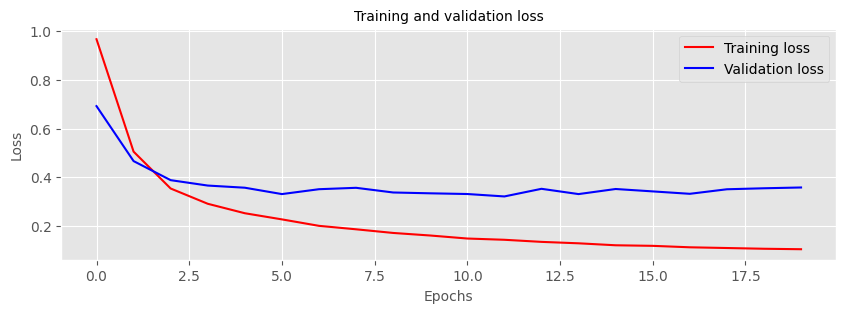

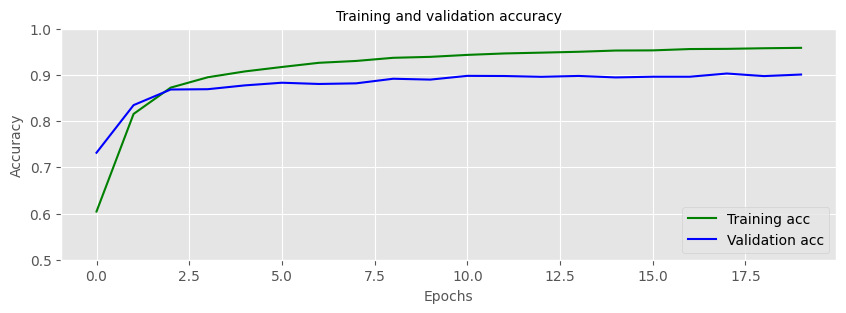

In [44]:
history_dict = history_1.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history_1.epoch

plt.figure(figsize=(10,3))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(10,3))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Accuracy', size=10)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

**Проверим работу модели на валидационной выборке.**

In [45]:
X_valid = valid_df.twit

In [46]:
X_valid = tokenizer.texts_to_sequences(X_valid)

In [47]:
X_valid = tf.keras.preprocessing.sequence.pad_sequences(X_valid, padding='post', maxlen=20)

In [48]:
y_valid = valid_df.le_emotion

In [49]:
model_1.evaluate(X_valid, y_valid)

32/32 [==============================] - 1s 27ms/step - loss: 0.3789 - accuracy: 0.9180


[0.378928542137146, 0.9180000424385071]

---

**Упросим модель**

In [50]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 64), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(4, activation='softmax'),
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          3200000   
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 3,266,564
Trainable params: 3,266,564
Non-trainable params: 0
_________________________________________________________________


In [51]:
checkpoint_cb_2 = tf.keras.callbacks.ModelCheckpoint("model_2.h5", 
                                     monitor = 'val_accuracy',
                                     save_best_only=True)

In [52]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
              metrics=['accuracy'])

**Обучим упрощенную модель**

In [53]:
history_2 = model_2.fit(X_train, y_train, 
                     epochs=30,
                     validation_split=0.1, 
                     batch_size=32, 
                     shuffle=True, 
                     callbacks=[checkpoint_cb_2],
                     verbose=0)

2023-03-15 16:24:24.319006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:24:24.504001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:24:24.517372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:24:24.690260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:24:24.706161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:25:11.797493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:25:11.866490: I tensorflow/core/grappler/optimizers/cust

**Оценим модель на тестовой выборке.**

In [54]:
model_2.evaluate(X_test, y_test)

2023-03-15 16:47:06.860375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:47:06.936125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-15 16:47:06.947065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


463/463 [==============================] - 6s 12ms/step - loss: 0.4740 - accuracy: 0.8945


[0.47401145100593567, 0.8945270776748657]

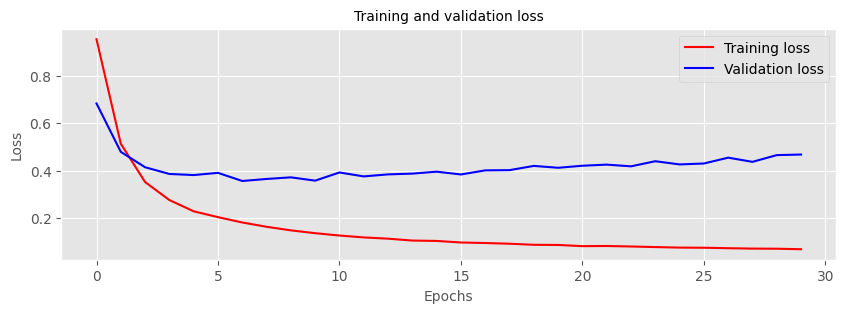

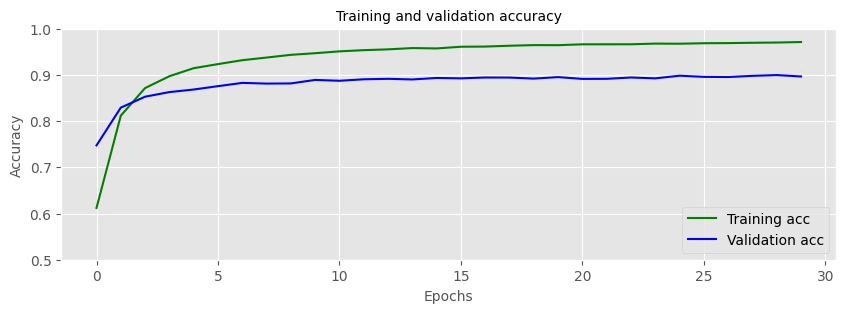

In [55]:
history_dict = history_2.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history_2.epoch

plt.figure(figsize=(10,3))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(10,3))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Accuracy', size=10)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

**Проверим работу модели на валидационной выборке.**

In [56]:
model_2.evaluate(X_valid, y_valid)

32/32 [==============================] - 1s 15ms/step - loss: 0.4280 - accuracy: 0.9290


[0.4280472695827484, 0.9290000200271606]